# Selected features

In [151]:
import pandas as pd
import matplotlib.pyplot as plt

In [152]:
df = pd.read_csv('SBAnational.csv')
df.columns

/var/folders/41/hgg8f6_j1dj4y4mt0w22d8ym0000gn/T/ipykernel_14388/3878241928.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('SBAnational.csv')


Index(['LoanNr_ChkDgt', 'Name', 'City', 'State', 'Zip', 'Bank', 'BankState',
       'NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist',
       'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr',
       'LowDoc', 'ChgOffDate', 'DisbursementDate', 'DisbursementGross',
       'BalanceGross', 'MIS_Status', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv'],
      dtype='object')

In [153]:
# I'm gonna drop a bumch of columns that I don't care about for now. I will leave the name for traceability.
drop_columns = ['LoanNr_ChkDgt', 'City', 'State', 'Zip', 'BankState', 'ApprovalDate', 'ApprovalFY',
                'CreateJob', 'RetainedJob', 'ChgOffDate', 'DisbursementDate', 'DisbursementGross',
                'BalanceGross', 'ChgOffPrinGr']
df.drop(drop_columns, inplace=True, axis=1)

In [154]:
df.head(3)

,Name,Bank,NAICS,Term,NoEmp,NewExist,FranchiseCode,UrbanRural,RevLineCr,LowDoc,MIS_Status,GrAppv,SBA_Appv
0,ABC HOBBYCRAFT,FIFTH THIRD BANK,451120,84,4,2.000,1,0,N,Y,P I F,"$60,000.00","$48,000.00"
1,LANDMARK BAR & GRILLE (THE),1ST SOURCE BANK,722410,60,2,2.000,1,0,N,Y,P I F,"$40,000.00","$32,000.00"
2,"WHITLOCK DDS, TODD M.",GRANT COUNTY STATE BANK,621210,180,7,1.000,1,0,N,N,P I F,"$287,000.00","$215,250.00"


## Direct Inclusion

Can be directly included or with minimum manipulation.

### Bank
Bank Name\
**Encoding:**\
One-Hot for tree-based models. An idea is to create a few columns like Bank A, Bank B, Bank C with the major banks.\
<mark>TODO: Identify most common banks.</mark> \
For regression models we could encode each bank with the percentage of default of its previous loans.\
**Cleaning:**\
1559 nulls.\
One-Hot should be able to fix nulls, as a null bank would just be 0 in each column.

In [155]:
df['Bank'].describe()


count                         897605
unique                          5802
top       BANK OF AMERICA NATL ASSOC
freq                           86853
Name: Bank, dtype: object

In [156]:
top_5_banks = df['Bank'].value_counts().head(5)
print(f"\nThe top 5 most common banks:")
top_5_banks


The top 5 most common banks:


Bank
BANK OF AMERICA NATL ASSOC        86853
WELLS FARGO BANK NATL ASSOC       63503
JPMORGAN CHASE BANK NATL ASSOC    48167
U.S. BANK NATIONAL ASSOCIATION    35143
CITIZENS BANK NATL ASSOC          35054
Name: count, dtype: int64

In [157]:
print(f"{len(df[df['Bank'].isnull()])} nulls")

1559 nulls


### NAICS
North American Industry Classification System code\
**Encoding:**\
It does not make sense as a float number. Needs to be changed to a string.\
One-Hot for tree-based models. We can do a similar encoding as in the *Bank* feature. See [census](https://www.census.gov/naics/?58967?yearbck=2012) for identifying the industries. Note: It's the 1997 naming for some reason, not the 2012 one. Probably they are even mixed.
<mark>TODO: Identify most common industries.</mark> \
For regression-based models we could do the same as for *bank* and just substitute it for its default ratio.\
**Cleaning:**\
A bunch of them have 0 value.
<mark>TODO: Decide what to do with the zeros.</mark> \

In [158]:
# Change to a string to get categorical descriptions.
df['NAICS'] = df['NAICS'].astype(str)
df['NAICS'].describe()

count     899164
unique      1312
top            0
freq      201948
Name: NAICS, dtype: object

In [159]:
top_naics = df['NAICS'].value_counts().head()
print(f"\nThe top 5 most common NAICS:")
top_naics


The top 5 most common NAICS:


NAICS
0         201948
722110     27989
722211     19448
811111     14585
621210     14048
Name: count, dtype: int64

### Term
Loan term in months\
**Encoding:**\
For regression models it is inmediate, being a numeric feature.\
For tree-based models we may have to build bins. An idea would be to divide it into short, medium and long terms.
<mark>TODO: Design bins to divide the terms.</mark>

In [160]:
df['Term'].describe()

count   899164.000
mean       110.773
std         78.857
min          0.000
25%         60.000
50%         84.000
75%        120.000
max        569.000
Name: Term, dtype: float64

In [161]:
# Helper function to draw histograms
def draw_histogram(column: pd.DataFrame, name: str, nbins: int = 10):
    plt.figure(figsize=(8, 6))
    plt.hist(column, bins=nbins, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {name}')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

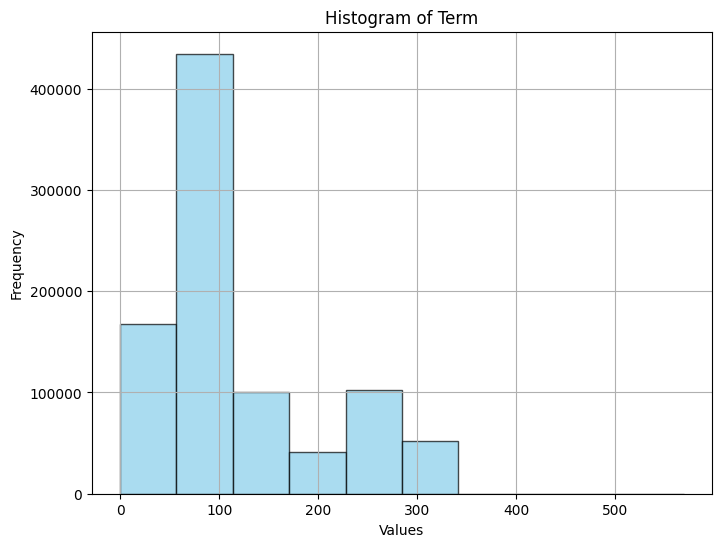

In [162]:
draw_histogram(df['Term'], 'Term')

### NoEmp
Number of Business Employees\
**Encoding:**\
For linear models it makes sense to use directly as a feature.\
For tree based models we might want to make bins for different business sizes.
<mark>TODO: Design bins to divide the business sizes.</mark>

In [163]:
df['NoEmp'].describe()

count   899164.000
mean        11.411
std         74.108
min          0.000
25%          2.000
50%          4.000
75%         10.000
max       9999.000
Name: NoEmp, dtype: float64

In [164]:
# These are some of the biggest ones. They could maybe be considered as outliers.
df[df['NoEmp'] >= 9800]

,Name,Bank,NAICS,Term,NoEmp,NewExist,FranchiseCode,UrbanRural,RevLineCr,LowDoc,MIS_Status,GrAppv,SBA_Appv
7816,"OAKS PHARMACY, INC.",CITIZENS BANK OF PENNSYLVANIA,446110,36,9992,2.000,1,0,N,Y,P I F,"$55,000.00","$44,000.00"
44584,R & R SALES,ALERUS FINANCIAL NATL ASSOC,0,84,9999,2.000,0,0,N,N,CHGOFF,"$50,000.00","$45,000.00"
164076,BRADLEY I. & LINDA M. AULIN,FIVE STAR BANK,0,63,9999,1.000,1,0,N,N,CHGOFF,"$200,000.00","$150,000.00"
505737,"TOTEM PRESS, INC.",U.S. BANK NATIONAL ASSOCIATION,0,120,9999,1.000,1,0,N,N,P I F,"$143,000.00","$114,400.00"
613940,GRAPHIC COMMUNICATION A HAWAII,FIRST HAWAIIAN BANK,541430,84,9999,1.000,1,0,N,N,P I F,"$21,000.00","$18,900.00"
873293,WILL'S FAMILY FAVORITES,CALIFORNIA BANK & TRUST,0,70,9945,1.000,1,0,0,N,P I F,"$145,000.00","$108,750.00"


In [165]:
# What should we do with the fellas with 0 employees?
print(f"{len(df[df['NoEmp'] < 1])} have 0 employees")

6631 have 0 employees


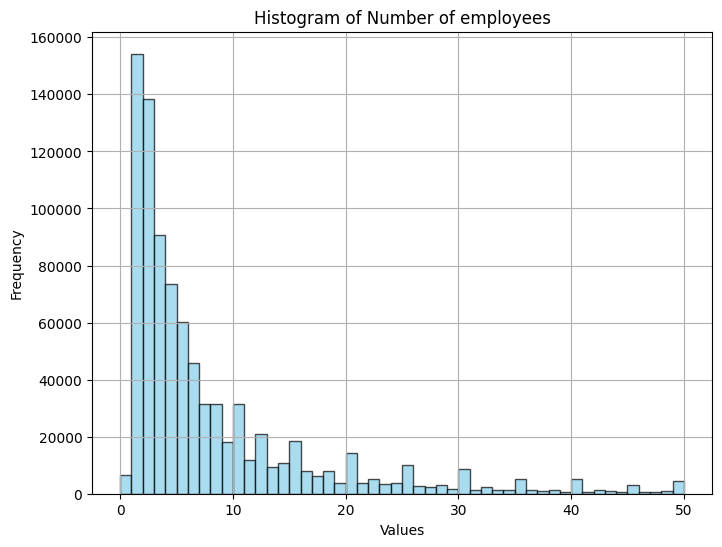

In [166]:
# I'll only pull the ones under 50 to see with bigger detail.
draw_histogram(df[df['NoEmp']<=50]['NoEmp'], "Number of employees", 50)

### NewExist
1 = Existing Business, 2 = New Business\
**Encoding:**\
For both trees and regressions, the encoding is straightforward binary, 1 = existing, 0 = new.\
**Cleaning:**\
1034 values with 0.0.\
We can fill them with the mode (Existing) or toss the samples.
<mark>TODO: Decide what to do with the nulls.</mark>

In [167]:
df['NewExist'] = df['NewExist'].astype(str)
df['NewExist'].describe()

count     899164
unique         4
top          1.0
freq      644869
Name: NewExist, dtype: object

In [168]:
# 136 nulls.
df['NewExist'].value_counts()

NewExist
1.0    644869
2.0    253125
0.0      1034
nan       136
Name: count, dtype: int64

### FranchiseCode
Franchise Code 00000 or 00001 = No Franchise\
**Encoding:**\
Has to be changed to strings.
For both tree and regression models it would be good to feature engineer it into a division between *no-franchise, major-franchise and other-franchise*. We could have one bin for Subway, Quiznos, etc; one for other franchises and one for no franchise.\
Some values included are:\
78760: Subway\
68020: Quiznos\
50564: Mail Boxes Etc\
21780: Dairy Queen\
25650: Dunkin\
79140: Super 8\
<mark>TODO: Design bins to divide the franchises.</mark>

In [169]:
df['FranchiseCode'] = df['FranchiseCode'].astype(str)
df['FranchiseCode'].describe()

count     899164
unique      2768
top            1
freq      638554
Name: FranchiseCode, dtype: object

In [170]:
top_franchises = df['FranchiseCode'].value_counts().head(10)
print(f"\nThe top 10 most common franchises:")
top_franchises


The top 10 most common franchises:


FranchiseCode
1        638554
0        208835
78760      3373
68020      1921
50564      1034
21780      1003
25650       715
79140       659
22470       615
17998       606
Name: count, dtype: int64

### UrbanRural
1= Urban, 2= Rural, 0 = Undefined\
**Encoding:**\
Changed to string. It has to be one-hot encoding for both trees and regression. 105343 are undefined, so it should be its own cathegory.

In [171]:
df['UrbanRural'] = df['UrbanRural'].astype(str)
df['UrbanRural'].describe()

count     899164
unique         3
top            1
freq      470654
Name: UrbanRural, dtype: object

In [172]:
df['UrbanRural'].value_counts()

UrbanRural
1    470654
0    323167
2    105343
Name: count, dtype: int64

### RevLineCr
Revolving Line of Credit: Y = Yes\
**Encoding:**\
Makes sense to binary-encode it for both trees and regression. \
**Cleaning:**\
There is a significative amount of possible values which don't have a clear meaning (i.e. 0, T, 1, R, 2, C). There are also nulls.
<mark>TODO: Clean this data. </mark>

In [173]:
df['RevLineCr'].describe()

count     894636
unique        18
top            N
freq      420288
Name: RevLineCr, dtype: object

In [174]:
df['RevLineCr'].value_counts()

RevLineCr
N    420288
0    257602
Y    201397
T     15284
1        23
R        14
`        11
2         6
C         2
3         1
,         1
7         1
A         1
5         1
.         1
4         1
-         1
Q         1
Name: count, dtype: int64

In [175]:
print(f"{len(df[df['RevLineCr'].isnull()])} nulls")

4528 nulls


### LowDoc
LowDoc Loan Program: Y = Yes, N = No\
**Encoding:**\
Makes sense to binary-encode it for both trees and regression. \
**Cleaning:**\
There is a significative amount of possible values which don't have a clear meaning (i.e. 0, C, S, A, 1). There are also nulls.
<mark>TODO: Clean this data. </mark>

In [176]:
df['LowDoc'].describe()

count     896582
unique         8
top            N
freq      782822
Name: LowDoc, dtype: object

In [177]:
df['LowDoc'].value_counts()

LowDoc
N    782822
Y    110335
0      1491
C       758
S       603
A       497
R        75
1         1
Name: count, dtype: int64

In [178]:
print(f"{len(df[df['LowDoc'].isnull()])} nulls")

2582 nulls


In [179]:
#Convert dollar values to float value
def dollar_to_float(dollar_string: str):
    return float(dollar_string.replace('$','').replace(',',''))

### GRAppv
Gross Amount of Loan Approved by Bank\
**Encoding:**\
Has to be translated into floats.

In [180]:
df['GrAppv'] = df['GrAppv'].apply(dollar_to_float)

# Scientific notation is useless for now
pd.set_option('display.float_format', lambda x: '%.3f' % x)

df['GrAppv'].describe()


count    899164.000
mean     192686.976
std      283263.391
min         200.000
25%       35000.000
50%       90000.000
75%      225000.000
max     5472000.000
Name: GrAppv, dtype: float64

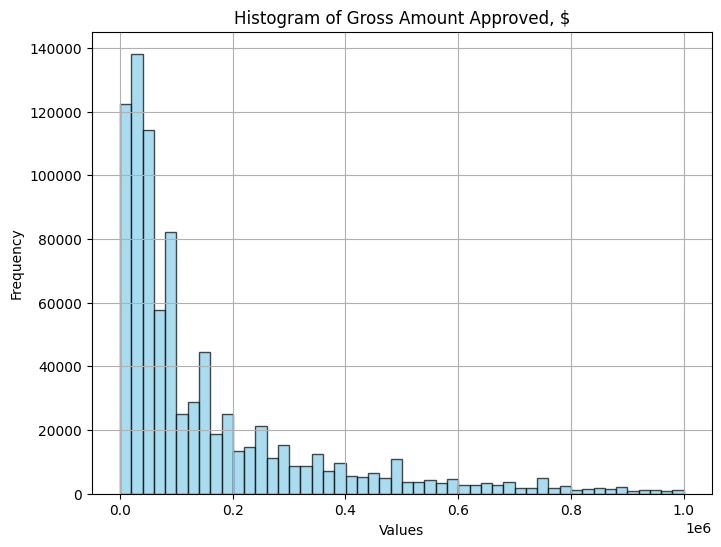

In [181]:
# I will go over the loans under $1 million.

draw_histogram(df[df['GrAppv'] < 1000000]['GrAppv'], 'Gross Amount Approved, $', 50)

### SBA_Appv
SBA’s Guaranteed Amount of Approved Loan\
**Encoding:**\
Has to be translated into floats.

In [182]:
df['SBA_Appv'] = df['SBA_Appv'].apply(dollar_to_float)
df['SBA_Appv'].describe()

count    899164.000
mean     149488.788
std      228414.562
min         100.000
25%       21250.000
50%       61250.000
75%      175000.000
max     5472000.000
Name: SBA_Appv, dtype: float64

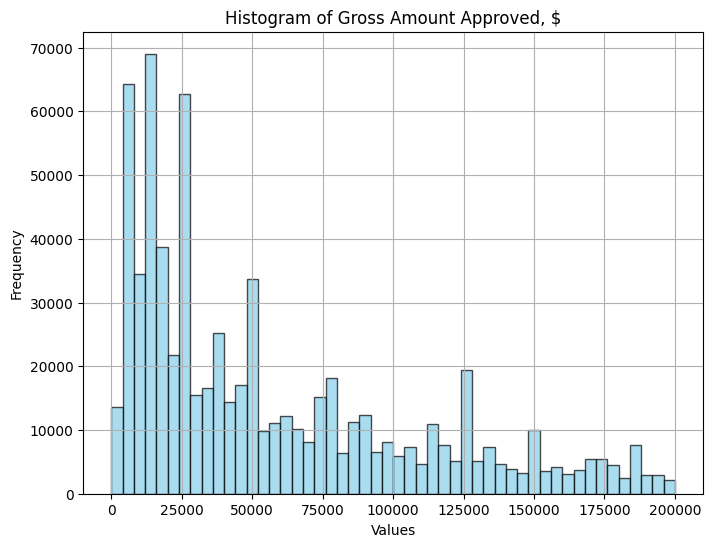

In [183]:
# I will go over the loans under $200k.

draw_histogram(df[df['SBA_Appv'] < 200000]['SBA_Appv'], 'Gross Amount Approved, $', 50)

## Engineered Features

In [ ]:
df['SBARatio'] = df['GrSBA_Appv'] / df['GrAppvFloat']